*Data Exploration and Analysis of the Scraped Data*

Here, we will deep more explore into the data, especially doing the Sentiment Analysis.

In [112]:
# Step 1: Install necessary packages, please do uncomment
#!pip3 install pandas scikit-learn
#!pip3 install vaderSentiment
#!pip install nltk
#!pip install wordcloud
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [113]:
# Define the library we will use
import pandas as pd
import nltk # For language processing, use NLTK library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from scipy.stats import ttest_ind, f_oneway
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os
from pathlib import Path
import re, os, ssl
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import scipy.stats as stats

In [114]:
# The code below is to make the image for the Visualization Purpose and Report
# Create images directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')
ssl._create_default_https_context = ssl._create_unverified_context

# Download NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mochammadmiftahulfahmi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mochammadmiftahulfahmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mochammadmiftahulfahmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


*Start the Analysis by reading the datasets*

In [115]:
# Read the csv files below, each of the brand has its own reviews fro TRUSTPILOT
reviews_whatsapp = pd.read_csv('./data/reviews_whatsapp.csv')
reviews_signal = pd.read_csv('./data/reviews_signal_org.csv')
reviews_discord = pd.read_csv('./data/reviews_discord.csv')

In [116]:
#Let us check the data that we already gained, how many reviews was scraped
num_reviews_whatsapp = len(reviews_whatsapp)
num_reviews_signal = len(reviews_signal)
num_reviews_discord = len(reviews_discord)

# Create a table with the number of reviews
data = {
    'Brand': ['WhatsApp', 'Signal', 'Discord'],
    'Number of Reviews': [num_reviews_whatsapp, num_reviews_signal, num_reviews_discord]
}

reviews_table = pd.DataFrame(data)
reviews_table

,Brand,Number of Reviews
0,WhatsApp,439
1,Signal,17
2,Discord,650


Next, to ensure that only English reviews are included in our analysis (especially we will do further analysis such as language-specific sentiment analysis or other language-dependent tasks),  it might be appropriate to include language detection as an additional step. 

In [117]:
import pandas as pd
from langdetect import detect_langs, DetectorFactory

# Set the seed for reproducibility
DetectorFactory.seed = 0

# Function to detect the language with probability scores
def detect_language(text):
    try:
        lang_probs = detect_langs(text)
        lang_dict = {lang.lang: lang.prob for lang in lang_probs}
        return lang_dict
    except:
        return {}

# Function to determine if English is the dominant language
def is_english_dominant(lang_probabilities):
    if 'en' in lang_probabilities and lang_probabilities['en'] > 0.5:
        return True
    else:
        return False

# Analysis for WhatsApp
reviews_whatsapp['Language_Probabilities'] = reviews_whatsapp['Body'].apply(detect_language)
english_dominant_whatsapp = reviews_whatsapp[reviews_whatsapp['Language_Probabilities'].apply(is_english_dominant)]

# Analysis for Signal
reviews_signal['Language_Probabilities'] = reviews_signal['Body'].apply(detect_language)
english_dominant_signal = reviews_signal[reviews_signal['Language_Probabilities'].apply(is_english_dominant)]

# Analysis for Discord
reviews_discord['Language_Probabilities'] = reviews_discord['Body'].apply(detect_language)
english_dominant_discord = reviews_discord[reviews_discord['Language_Probabilities'].apply(is_english_dominant)]

# Display the number of English-dominant reviews for each app
print("Number of English-Dominant Reviews for WhatsApp:", len(english_dominant_whatsapp))
print("Number of English-Dominant Reviews for Signal:", len(english_dominant_signal))
print("Number of English-Dominant Reviews for Discord:", len(english_dominant_discord))


Number of English-Dominant Reviews for WhatsApp: 427
Number of English-Dominant Reviews for Signal: 16
Number of English-Dominant Reviews for Discord: 644


In [118]:
# Function to determine if non-English is the dominant language
def is_non_english_dominant(lang_probabilities):
    if 'en' not in lang_probabilities or lang_probabilities['en'] < 0.5:
        return True
    else:
        return False

# Non-English reviews for WhatsApp
non_english_whatsapp = reviews_whatsapp[reviews_whatsapp['Language_Probabilities'].apply(is_non_english_dominant)]

# Non-English reviews for Signal
non_english_signal = reviews_signal[reviews_signal['Language_Probabilities'].apply(is_non_english_dominant)]

# Non-English reviews for Discord
non_english_discord = reviews_discord[reviews_discord['Language_Probabilities'].apply(is_non_english_dominant)]

# Display the non-English reviews for each app
print("Non-English Reviews for WhatsApp:")
print(non_english_whatsapp)

print("\nNon-English Reviews for Signal:")
print(non_english_signal)

print("\nNon-English Reviews for Discord:")
print(non_english_discord)


Non-English Reviews for WhatsApp:
           Date                         Author  \
20   2023-12-03                   Veeru Sonkar   
69   2023-09-11                       A. S. R.   
83   2019-09-28                 Udhesh Pradesh   
191  2023-12-29                      Malte Fog   
290  2021-10-04            chaosgirl Minecraft   
304  2023-12-30                Ahmed Awadallah   
342  2023-12-05                           Reya   
343  2023-10-28                     Bart Poole   
363  2020-11-21                  Kate Fletcher   
369  2017-10-20  Syed Affan Raza Salman Kaskar   
381  2020-09-03                 The Lanka Tech   
390  2020-07-30                         wykaaa   

                                                  Body  \
20                                          Nonononono   
69   THROUGH THE DECADE THEY HAVE TORTURED THE GENE...   
83   Why do you keep banning the GB version? It doe...   
191                                         …………………***   
290     It doesn't work i

From above code, there are only *actually* 2 reviews in both Whatsapp (row 342 and 390) and Discord (row 209 and 548). This is minor compared to the size of the reviews per brand, so we can ignore it. Further, these reviews written French or Spanish will be excluded during the "word removing" part below.

But first, let us tidy up the data again, practically.

In [119]:
# Combine datasets to a single file, for easier analysis
reviews_whatsapp['brand'] = 'WhatsApp'
reviews_signal['brand'] = 'Signal'
reviews_discord['brand'] = 'Discord'

reviews = pd.concat([reviews_whatsapp, reviews_signal, reviews_discord], ignore_index=True)
reviews.head()

,Date,Author,Body,Heading,Rating,Location,Language_Probabilities,brand
0,2022-02-10,Linh Nguyen,Not a good experience so far. the app has a lo...,Not a good experience so far,2,VN,{'en': 0.999996475562891},WhatsApp
1,2019-10-18,Daniel,"I use whatsapp most days, well made and easy t...",Brilliant app,4,GB,{'en': 0.9999957413579668},WhatsApp
2,2020-08-16,Football HD,Very very cool application \nIt's easy and use...,Very very cool application,5,MA,{'en': 0.9999971682137935},WhatsApp
3,2022-02-10,Marius B,I have been listened by WhatsApp while speakin...,Conversations are not actually private.,1,GB,{'en': 0.9999979057006777},WhatsApp
4,2022-12-31,Sandra,The WhatsApp support is a total pile of crap. ...,The WhatsApp support is a total pile of…,1,AU,{'en': 0.9999969529226641},WhatsApp


In [120]:
# Further check the type of the data per column, and make sure that there is no NULL DATA
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    1106 non-null   object
 1   Author                  1105 non-null   object
 2   Body                    1106 non-null   object
 3   Heading                 1106 non-null   object
 4   Rating                  1106 non-null   int64 
 5   Location                1104 non-null   object
 6   Language_Probabilities  1106 non-null   object
 7   brand                   1106 non-null   object
dtypes: int64(1), object(7)
memory usage: 69.2+ KB


In [121]:
reviews.columns

Index(['Date', 'Author', 'Body', 'Heading', 'Rating', 'Location',
       'Language_Probabilities', 'brand'],
      dtype='object')

Start the Text Analysis here

In [122]:
# Define the functions to preprocess text
def preprocess_text(text):
    # First, we need to Remove punctuation, numbers, and words with length <= 2
    # It is needed so that the text is cleaned, to reduce noise and focus on meaningful words.
    text = re.sub(r'[^\w\s\d]', '', text)  # Include \d to remove numbers
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

# Second, Apply text preprocessing to the 'Body' column, this standardizes the text data across all reviews to ensure consistency.
reviews['Body'] = reviews['Body'].apply(preprocess_text)

# Tokenize the 'Body' column of the dataframe
# This third one is important because it converts the cleaned text into individual words, 
# Necessary step for most text analysis techniques.
reviews['Tokens'] = reviews['Body'].apply(lambda x: word_tokenize(x))

In [123]:
# Next, we further clean the data by cleaning the stopwords and profanity
#Removing Stopwords and Profanity: Stopwords are common words like 'and', 'the', 'is', etc., that often do not carry significant meaning. 
#For this, we'll use the nltk library's built-in stopwords list.

# Download stopwords list
nltk.download('stopwords') # This works in English only
stop_words = set(stopwords.words('english'))

# And of course, remove stopwords
reviews['Cleaned_Tokens'] = reviews['Tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mochammadmiftahulfahmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
#Stemming: Stemming involves reducing words to their root form. We'll use the spaCy library for this task.

# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define function for stemming using SpaCy
def spacy_stemming(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# Apply SpaCy stemming to the 'Cleaned Tokens' column
reviews['Stemmed_Tokens'] = reviews['Cleaned_Tokens'].apply(lambda x: spacy_stemming(' '.join(x)))


In [125]:
reviews.head()

,Date,Author,Body,Heading,Rating,Location,Language_Probabilities,brand,Tokens,Cleaned_Tokens,Stemmed_Tokens
0,2022-02-10,Linh Nguyen,Not good experience far the app has lot proble...,Not a good experience so far,2,VN,{'en': 0.999996475562891},WhatsApp,"[Not, good, experience, far, the, app, has, lo...","[good, experience, far, app, lot, problems, ma...","[good, experience, far, app, lot, problem, man..."
1,2019-10-18,Daniel,use whatsapp most days well made and easy use ...,Brilliant app,4,GB,{'en': 0.9999957413579668},WhatsApp,"[use, whatsapp, most, days, well, made, and, e...","[use, whatsapp, days, well, made, easy, use, c...","[use, whatsapp, day, well, make, easy, use, ch..."
2,2020-08-16,Football HD,Very very cool application Its easy and useful...,Very very cool application,5,MA,{'en': 0.9999971682137935},WhatsApp,"[Very, very, cool, application, Its, easy, and...","[cool, application, easy, useful, app, post, s...","[cool, application, easy, useful, app, post, s..."
3,2022-02-10,Marius B,have been listened WhatsApp while speaking wit...,Conversations are not actually private.,1,GB,{'en': 0.9999979057006777},WhatsApp,"[have, been, listened, WhatsApp, while, speaki...","[listened, WhatsApp, speaking, friend, certain...","[listen, WhatsApp, speak, friend, certain, sub..."
4,2022-12-31,Sandra,The WhatsApp support total pile crap They dont...,The WhatsApp support is a total pile of…,1,AU,{'en': 0.9999969529226641},WhatsApp,"[The, WhatsApp, support, total, pile, crap, Th...","[WhatsApp, support, total, pile, crap, dont, r...","[whatsapp, support, total, pile, crap, do, not..."


In [126]:
reviews.columns

Index(['Date', 'Author', 'Body', 'Heading', 'Rating', 'Location',
       'Language_Probabilities', 'brand', 'Tokens', 'Cleaned_Tokens',
       'Stemmed_Tokens'],
      dtype='object')

Next, we will do **TF-IDF Analysis**

TF-IDF is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents.
It is calculated by multiplying two values: Term Frequency (TF) and Inverse Document Frequency (IDF).

In [127]:
#Applying Frequency Filters and Consolidating Synonyms: For this step, we'll use techniques like 
#TF-IDF (Term Frequency-Inverse Document Frequency) to filter out low-frequency words and consolidate synonyms. 
#We'll use the scikit-learn library for this task.

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))


Next, do the topic classification (not literally classification as in supervised ML), but to categorize the important topics.

This code below 
1) initializes a CountVectorizer to convert text data into a matrix of token counts, 
2) fits and transforms the text data, 
3) initializes and fits an LDA model to extract topics from the text data, and 
4) finally prints the top words for each extracted topic. 

This process allows for topic modeling and exploration of themes within the text data.

In [128]:
# Initialize CountVectorizer to convert text to a matrix of token counts
count_vectorizer = CountVectorizer()

# Fit and transform the text data
count_matrix = count_vectorizer.fit_transform(reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))

# Initialize LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics (n_components)

# Fit LDA model
lda_model.fit(count_matrix)

# Get the topics
topics = lda_model.components_

# Print top words for each topic
for i, topic in enumerate(topics):
    top_words_indices = topic.argsort()[-10:]  # Print top 10 words
    top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    print(f"Topic {i+1}: {', '.join(top_words)}")


Topic 1: good, time, customer, chat, get, not, use, message, app, whatsapp
Topic 2: whatsapp, do, group, number, get, not, call, use, phone, app
Topic 3: server, email, even, use, support, do, get, account, not, discord
Topic 4: get, app, bad, do, phone, number, use, support, not, account
Topic 5: time, message, app, ban, people, support, user, account, use, discord


This code performs sentiment analysis using **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, a lexicon and rule-based sentiment analysis tool specifically designed for analyzing sentiments expressed in social media texts.

The sentiment score returned by VADER is a compound score **ranging from -1 (most negative) to 1 (most positive)**, with scores close to 0 indicating neutral sentiment.

In [129]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function to calculate sentiment scores using VADER
def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Calculate sentiment scores using VADER
reviews['Sentiment_Score'] = reviews['Body'].apply(vader_sentiment)

# Initialize CountVectorizer to convert text to a matrix of token counts
count_vectorizer = CountVectorizer()

# Fit and transform the text data
count_matrix = count_vectorizer.fit_transform(reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))

# Initialize LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust the number of topics as needed

# Fit LDA model
lda_model.fit(count_matrix)

# Get the topics
topics = lda_model.components_

# Group reviews by brand and topic
brand_topic_reviews = reviews.groupby(['brand', lda_model.transform(count_matrix).argmax(axis=1)])['Sentiment_Score'].mean()

# Print average sentiment score for each brand and topic
brand_topic_reviews

brand      
Discord   0    0.175224
          1   -0.339700
          2   -0.149207
          3   -0.168089
          4   -0.320562
Signal    0    0.637489
          1   -0.026500
          2    0.327060
          3   -0.226300
WhatsApp  0    0.283585
          1   -0.044054
          2    0.124111
          3    0.036125
          4   -0.151954
Name: Sentiment_Score, dtype: float64

In [130]:
# Get the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()

# Print top words for each topic
num_top_words = 20  # Number of top words to display
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[-num_top_words:]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: contact, call, work, phone, send, well, do, support, problem, service, good, time, customer, chat, get, not, use, message, app, whatsapp
Topic 1: go, make, money, say, try, never, people, message, one, tell, whatsapp, do, group, number, get, not, call, use, phone, app
Topic 2: friend, bad, like, send, ve, service, say, make, people, app, server, email, even, use, support, do, get, account, not, discord
Topic 3: reply, access, try, discord, whatsapp, email, reason, help, ve, customer, get, app, bad, do, phone, number, use, support, not, account
Topic 4: whatsapp, review, also, business, bot, not, report, service, kid, platform, time, message, app, ban, people, support, user, account, use, discord


In [131]:
reviews.columns

Index(['Date', 'Author', 'Body', 'Heading', 'Rating', 'Location',
       'Language_Probabilities', 'brand', 'Tokens', 'Cleaned_Tokens',
       'Stemmed_Tokens', 'Sentiment_Score'],
      dtype='object')

**FAHMI**

In [132]:
# Top most positive sentiment per brand
top_positive_per_brand = reviews.groupby('brand').apply(lambda x: x.nlargest(1, 'Sentiment_Score'))

# Top most negative sentiment per brand
top_negative_per_brand = reviews.groupby('brand').apply(lambda x: x.nsmallest(1, 'Sentiment_Score'))

# Display the results
print("Top Most Positive Sentiment per Brand:")
print(top_positive_per_brand[['brand', 'Author', 'Body', 'Sentiment_Score']])

print("\nTop Most Negative Sentiment per Brand:")
print(top_negative_per_brand[['brand', 'Author', 'Body', 'Sentiment_Score']])


Top Most Positive Sentiment per Brand:
                 brand                  Author  \
brand                                            
Discord  706   Discord          Crypto Discord   
Signal   446    Signal           Chetan Bhasin   
WhatsApp 33   WhatsApp  Powerful spells caster   

                                                           Body  \
brand                                                             
Discord  706  Honestly the bad reviews are just venting abou...   
Signal   446  Its got some catching but already very very ha...   
WhatsApp 33   Powerful spells caster psychic reading palmist...   

              Sentiment_Score  
brand                          
Discord  706           0.9953  
Signal   446           0.9939  
WhatsApp 33            0.9858  

Top Most Negative Sentiment per Brand:
                 brand            Author  \
brand                                      
Discord  558   Discord  Professor Zephyr   
Signal   448    Signal              Ilya  

**HERE**, we do some trial:
1) Do LDA and see about the topics
2) Do 3-words phase extraction, as recommended by Chat GPT 

In [133]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to extract top positive phrases from reviews
def extract_positive_phrases(reviews):
    positive_reviews = reviews[reviews['Sentiment_Score'] > 0.7]  # Adjust threshold as needed
    phrase_counts = Counter()
    for text in positive_reviews['Body']:
        words = text.split()
        for i in range(len(words) - 1):
            phrase = ' '.join(words[i:i+3])  # Extract 2-word phrases >>>>>>>>>>>>>>>>>>>>>>>>>>>>
            phrase_counts[phrase] += 1
    top_phrases = phrase_counts.most_common(10)  # Adjust top_n as needed
    return [phrase for phrase, _ in top_phrases]

# Function to extract top words from topics
def extract_top_words(lda_model, count_vectorizer, top_n=10):
    topics = lda_model.components_
    top_words_per_topic = []
    for topic in topics:
        top_words_indices = topic.argsort()[-top_n:]
        top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract positive phrases
    positive_phrases_brand = extract_positive_phrases(brand_reviews)
    print("Top Positive Phrases:")
    print(positive_phrases_brand)
    
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer_brand = CountVectorizer(ngram_range=(2, 2))  # Extract 2-word phrases
    # Fit and transform the text data
    count_matrix_brand = count_vectorizer_brand.fit_transform(brand_reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model
    lda_model_brand = LatentDirichletAllocation(n_components=5, random_state=42)
    # Fit LDA model
    lda_model_brand.fit(count_matrix_brand)
    # Extract top words from topics
    top_words_per_topic_brand = extract_top_words(lda_model_brand, count_vectorizer_brand)
    print("Top Topics:")
    for i, top_words in enumerate(top_words_per_topic_brand):
        print(f"Topic {i+1}: {', '.join(top_words)}")



Brand: WhatsApp
Top Positive Phrases:
['with friends and', 'family and friends', 'friends and family', 'and easy use', 'Thanks for your', 'and video calling', 'love this app', 'they tell you', 'still the best', 'many many friends']
Top Topics:
Topic 1: phone number, absolutely nothing, whatsapp support, every time, great app, easy use, send message, customer service, use whatsapp, do not
Topic 2: support team, customer service, use whatsapp, not understand, phone number, whatsapp business, use app, customer support, can not, do not
Topic 3: good app, use whatsapp, terrible customer, message whatsapp, like whatsapp, delete message, what app, can not, customer service, do not
Topic 4: waste time, bad customer, privacy policy, whatsapp good, family friend, what app, can not, use whatsapp, customer service, do not
Topic 5: phone number, use app, use whatsapp, video call, good app, not want, message photo, customer service, can not, do not

Brand: Signal
Top Positive Phrases:
['cant transf

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to extract top topics from reviews
def extract_topics(reviews):
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2, stop_words='english')  # Using bigrams, adjusting min_df and max_df, and removing English stop words
    # Fit and transform the text data
    count_matrix = count_vectorizer.fit_transform(reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model with adjusted parameters
    lda_model = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch', max_iter=50, evaluate_every=5, n_jobs=-1)  # Adjusting max_iter and learning_method
    # Fit LDA model
    lda_model.fit(count_matrix)
    # Extract top words from topics
    top_words_per_topic = []
    for topic in lda_model.components_:
        top_words_indices = topic.argsort()[-10:]  # Adjusting top_n as needed
        top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract topics from positive reviews
    positive_reviews = brand_reviews[brand_reviews['Sentiment_Score'] > 0.5]  # Filter positive reviews
    top_topics = extract_topics(positive_reviews)
    print("Top Topics:")
    for i, top_words in enumerate(top_topics):
        print(f"Topic {i+1}: {', '.join(top_words)}")



Brand: WhatsApp


Top Topics:
Topic 1: love, like, easy, app, message, device, service, chat, use, whatsapp
Topic 2: contact, video, send, good, people, app, whatsapp, phone, number, use
Topic 3: like, friend, support, customer, work, service, phone, app, use, whatsapp
Topic 4: chat, time, communication, message, feature, great, good, use, whatsapp, app
Topic 5: alot, fix, waste time, waste, help, user, time, number, problem, support

Brand: Signal
Top Topics:
Topic 1: secure, good, signal, feature, service, annoying, whatsapp, people, message, app
Topic 2: mean, encryption, endtoend encryption, endtoend, prefer, service, happy, way, strong, app
Topic 3: sure, support, use, signal, happy, way, work, app, good, secure
Topic 4: good, happy, way, work, sure, use, message, support, signal, phone
Topic 5: encryption, mean, say, work, apple, friend, good, feature, signal, support

Brand: Discord
Top Topics:
Topic 1: customer, server, friend, use, number, email, say, support, discord, account
Topic 2: server, 

We can see that the output of **THE 3-WORDS extraction can be quite insightful and easy to be digested by marketing team**

Thus we will combine LDA (5 topics) and 3-words extraction.

**WORDCLOUD ANALYSIS**

In General, we will do three:
1) Top Positive Analysis --> do LDA + 3-words extraction.
2) Top Negative Analysis --> do LDA + 3-words extraction.

First, Top Positive Analysis below

In [135]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to extract top positive phrases from reviews
def extract_positive_phrases(reviews):
    positive_reviews = reviews[reviews['Sentiment_Score'] > 0.7]  # Adjust threshold as needed
    phrase_counts = Counter()
    for text in positive_reviews['Body']:
        words = text.split()
        for i in range(len(words) - 1):
            phrase = ' '.join(words[i:i+2])  # Extract 2-word phrases >>>>>>>>>>>>>>>>>>>>>>>>>>>>
            phrase_counts[phrase] += 1
    top_phrases = phrase_counts.most_common(10)  # Adjust top_n as needed
    return [phrase for phrase, _ in top_phrases]

# Function to extract top words from topics
def extract_top_words(lda_model, count_vectorizer, top_n=10):
    topics = lda_model.components_
    top_words_per_topic = []
    for topic in topics:
        top_words_indices = topic.argsort()[-top_n:]
        top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract positive phrases
    positive_phrases_brand = extract_positive_phrases(brand_reviews)
    print("Top Positive Phrases:")
    print(positive_phrases_brand)
    
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer_brand = CountVectorizer(ngram_range=(2, 2))  # Extract 2-word phrases
    # Fit and transform the text data
    count_matrix_brand = count_vectorizer_brand.fit_transform(brand_reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model
    lda_model_brand = LatentDirichletAllocation(n_components=5, random_state=42)
    # Fit LDA model
    lda_model_brand.fit(count_matrix_brand)
    # Extract top words from topics
    top_words_per_topic_brand = extract_top_words(lda_model_brand, count_vectorizer_brand)
    print("Top Topics:")
    for i, top_words in enumerate(top_words_per_topic_brand):
        print(f"Topic {i+1}: {', '.join(top_words)}")



Brand: WhatsApp
Top Positive Phrases:
['this app', 'the best', 'phone number', 'and video', 'with friends', 'friends and', 'the app', 'has been', 'customer service', 'you can']
Top Topics:
Topic 1: phone number, absolutely nothing, whatsapp support, every time, great app, easy use, send message, customer service, use whatsapp, do not
Topic 2: support team, customer service, use whatsapp, not understand, phone number, whatsapp business, use app, customer support, can not, do not
Topic 3: good app, use whatsapp, terrible customer, message whatsapp, like whatsapp, delete message, what app, can not, customer service, do not
Topic 4: waste time, bad customer, privacy policy, whatsapp good, family friend, what app, can not, use whatsapp, customer service, do not
Topic 5: phone number, use app, use whatsapp, video call, good app, not want, message photo, customer service, can not, do not

Brand: Signal
Top Positive Phrases:
['chats without', 'old phone', 'with the', 'endtoend encryption', 'a

Worldcloud from LDA (the 5 topics combined)


Brand: WhatsApp
Top Topics:
Combined Top Words:


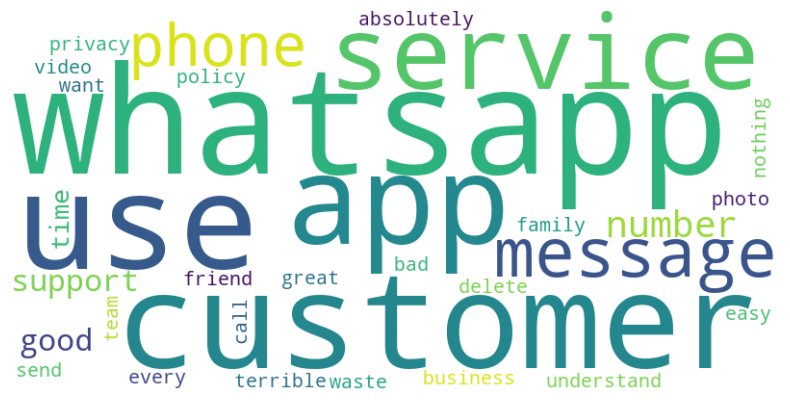


Brand: Signal
Top Topics:
Combined Top Words:


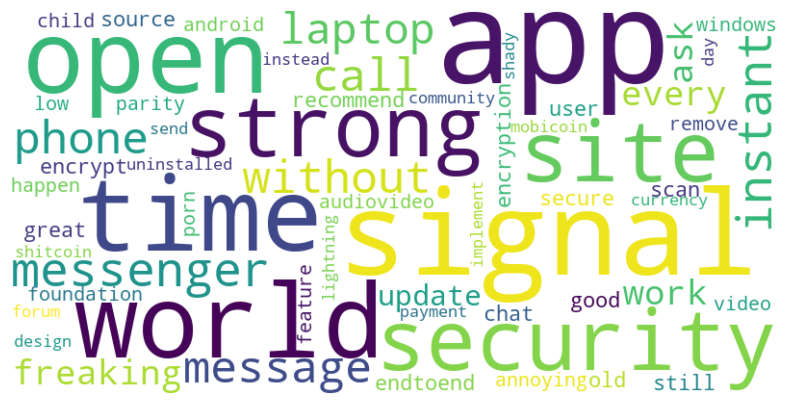


Brand: Discord
Top Topics:
Combined Top Words:


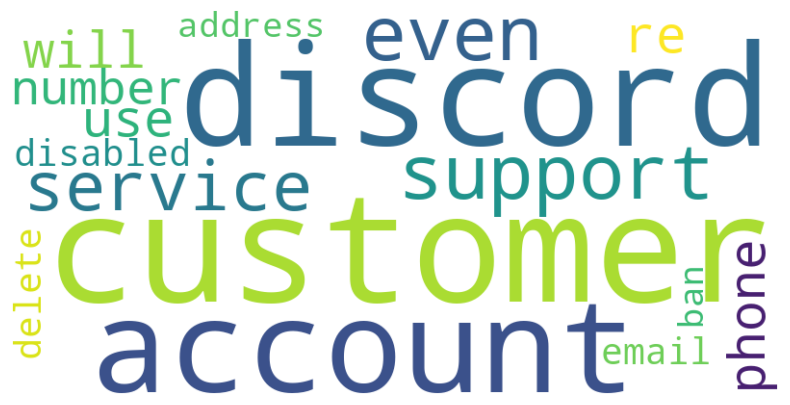

In [136]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display word cloud
def generate_wordcloud(words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract positive phrases
    positive_phrases_brand = extract_positive_phrases(brand_reviews)
    #print("Top Positive Phrases:")
    #print(positive_phrases_brand)
    
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer_brand = CountVectorizer(ngram_range=(2, 2))  # Extract 2-word phrases
    # Fit and transform the text data
    count_matrix_brand = count_vectorizer_brand.fit_transform(brand_reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model
    lda_model_brand = LatentDirichletAllocation(n_components=5, random_state=42)
    # Fit LDA model
    lda_model_brand.fit(count_matrix_brand)
    # Extract top words from topics
    top_words_per_topic_brand = extract_top_words(lda_model_brand, count_vectorizer_brand)
    print("Top Topics:")
    
    # Combine top words from all topics
    all_top_words = [word for topic_words in top_words_per_topic_brand for word in topic_words]
    
    # Generate and display word cloud
    print("Combined Top Words:")
    generate_wordcloud(all_top_words)


We can see that there is still brand name used many times! We need to remove this from analysis!

**Wordcloud from LDA, but without the brand name!**


Brand: WhatsApp
Top Topics:
Topic 1: phone number, absolutely nothing, whatsapp support, every time, great app, easy use, send message, customer service, use whatsapp, do not
Topic 2: support team, customer service, use whatsapp, not understand, phone number, whatsapp business, use app, customer support, can not, do not
Topic 3: good app, use whatsapp, terrible customer, message whatsapp, like whatsapp, delete message, what app, can not, customer service, do not
Topic 4: waste time, bad customer, privacy policy, whatsapp good, family friend, what app, can not, use whatsapp, customer service, do not
Topic 5: phone number, use app, use whatsapp, video call, good app, not want, message photo, customer service, can not, do not
Combined Top Words:


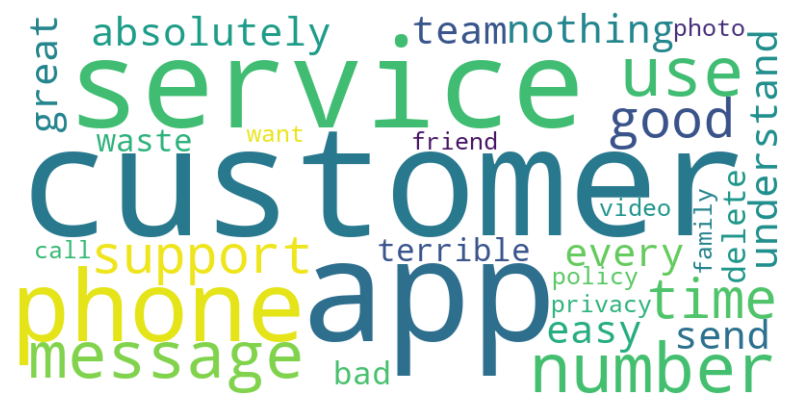


Brand: Signal
Top Topics:
Topic 1: security user, strong security, great app, app strong, site app, good site, messenger world, instant messenger, secure instant, world recommend
Topic 2: open source, encrypt message, message app, chat without, old phone, without scan, endtoend encryption, signal still, audiovideo call, do not
Topic 3: feature parity, android windows, time open, open laptop, freaking time, laptop ask, work every, ask update, update annoying, every freaking
Topic 4: remove time, phone do, do not, child porn, signal foundation, signal happen, video call, low signal, community forum, can not
Topic 5: instead uninstalled, app send, design shitcoin, lightning payment, day mobicoin, currency world, implement shady, not work, do not, can not
Combined Top Words:


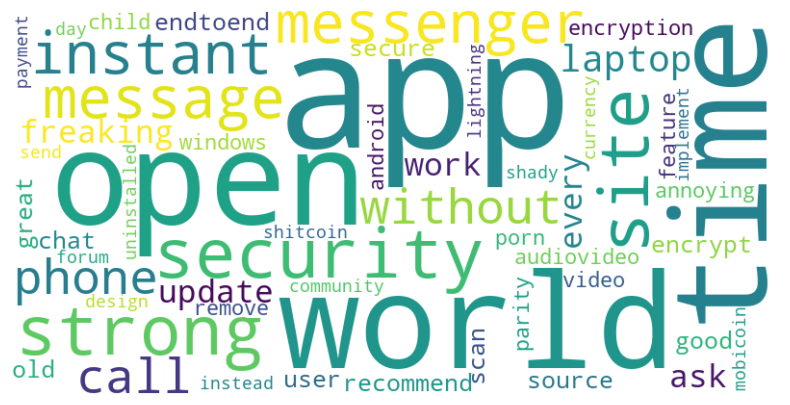


Brand: Discord
Top Topics:
Topic 1: not get, will not, they re, discord support, account get, customer service, use discord, not even, can not, do not
Topic 2: you re, account disabled, phone number, could not, be not, customer service, not even, can not, will not, do not
Topic 3: discord do, have not, delete account, not even, email address, be not, use discord, can not, customer support, do not
Topic 4: phone number, have not, not even, not get, account get, be not, customer service, customer support, can not, do not
Topic 5: get account, discord account, discord support, not even, get ban, customer support, be not, customer service, can not, do not
Combined Top Words:


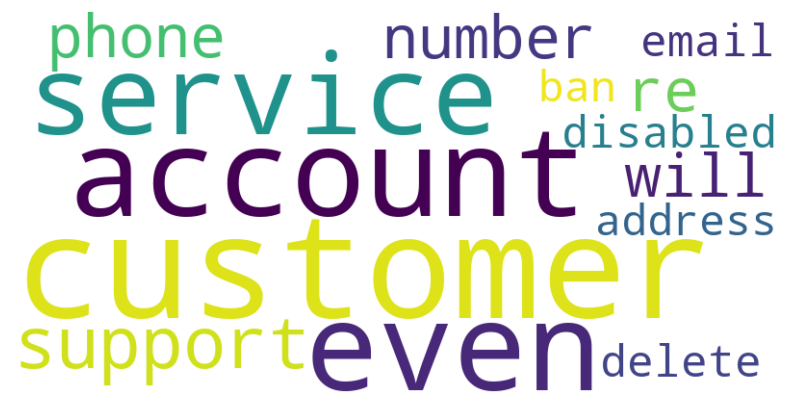

In [137]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display word cloud
def generate_wordcloud(words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract positive phrases
    positive_phrases_brand = extract_positive_phrases(brand_reviews)
    #print("Top Positive Phrases:")
    #print(positive_phrases_brand)
    
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer_brand = CountVectorizer(ngram_range=(2, 2))  # Extract 2-word phrases
    # Fit and transform the text data
    count_matrix_brand = count_vectorizer_brand.fit_transform(brand_reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model
    lda_model_brand = LatentDirichletAllocation(n_components=5, random_state=42)
    # Fit LDA model
    lda_model_brand.fit(count_matrix_brand)
    # Extract top words from topics
    top_words_per_topic_brand = extract_top_words(lda_model_brand, count_vectorizer_brand)
    print("Top Topics:")
    for i, top_words in enumerate(top_words_per_topic_brand):
        print(f"Topic {i+1}: {', '.join(top_words)}")
    
    # Combine top words from all topics, excluding the brand name
    all_top_words = [word for topic_words in top_words_per_topic_brand for word in topic_words if brand.lower() not in word.lower()]
    
    # Generate and display word cloud
    print("Combined Top Words:")
    generate_wordcloud(all_top_words)


Wordcloud from 3 words phrases


Brand: WhatsApp
Top Positive Phrases:
['this app', 'the best', 'and video', 'phone number', 'with friends', 'friends and', 'the app', 'has been', 'customer service', 'you can', 'that you', 'app and', 'and its', 'using this', 'video calling', 'you have', 'all your', 'dont have', 'can use', 'great app', 'not even', 'you are', 'for free', 'and the', 'with this', 'family and', 'and easy', 'and then', 'Thanks for', 'for your', 'app for', 'communicate with', 'whats app', 'use this', 'and they', 'they have', 'use and', 'that can', 'messaging app', 'app has', 'WhatsApp has', 'help and', 'for the', 'the world', 'you dont', 'and friends', 'and family', 'this service', 'Brian Boitano', 'have been']
Word Cloud:


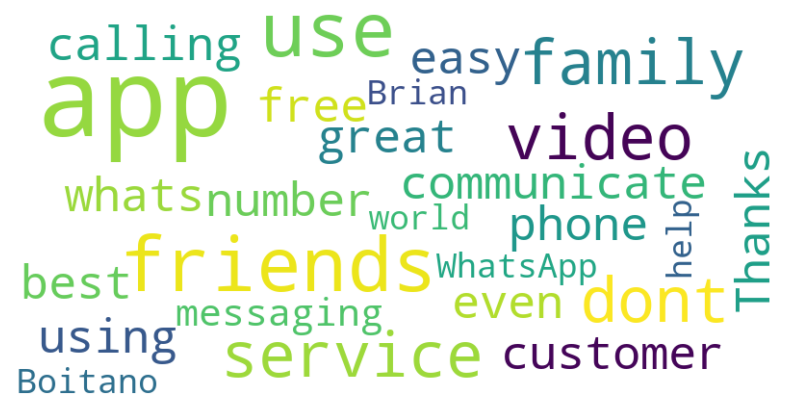


Brand: Signal
Top Positive Phrases:
['chats without', 'old phone', 'with the', 'endtoend encryption', 'audiovideo call', 'Signal still', 'because MMS', 'community forum', 'cant transfer', 'transfer old', 'old chats', 'without scanning', 'scanning old', 'phone Problem', 'Problem the', 'the camera', 'camera old', 'phone doesnt', 'doesnt work', 'work and', 'and the', 'the only', 'only answer', 'answer got', 'got from', 'from their', 'their support', 'support was', 'was one', 'one chatbot', 'chatbot that', 'that didnt', 'didnt respond', 'respond actual', 'actual problem', 'problem please', 'please there', 'there any', 'any other', 'other way', 'way transferring', 'transferring chats', 'without having', 'having scan', 'scan this', 'this code', 'code happy', 'happy hear', 'hear from', 'from signal']
Word Cloud:


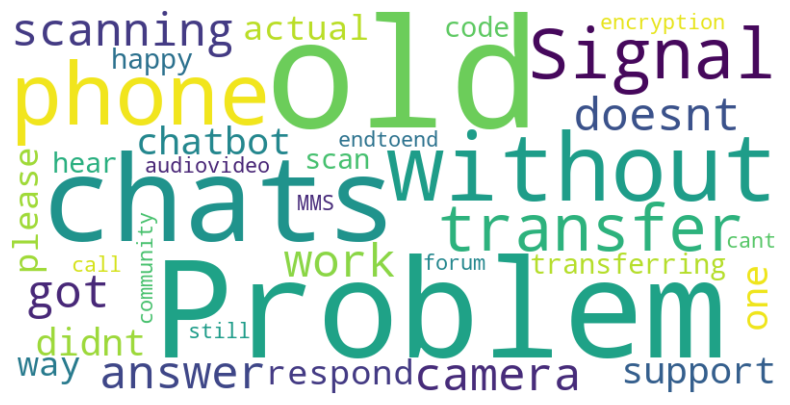


Brand: Discord
Top Positive Phrases:
['with the', 'for the', 'the same', 'and the', 'the app', 'your account', 'the best', 'they are', 'you can', 'have been', 'account was', 'all the', 'with friends', 'Discord has', 'phone number', 'that the', 'and they', 'customer service', 'email address', 'account and', 'dont know', 'been using', 'Discord for', 'with your', 'your friends', 'out there', 'their support', 'care about', 'that you', 'account for', 'screen share', 'from the', 'the support', 'Ive been', 'connect with', 'that they', 'with their', 'you are', 'You can', 'app and', 'this app', 'friends and', 'people who', 'know what', 'they dont', 'the discord', 'new account', 'was disabled', 'you have', 'the email']
Word Cloud:


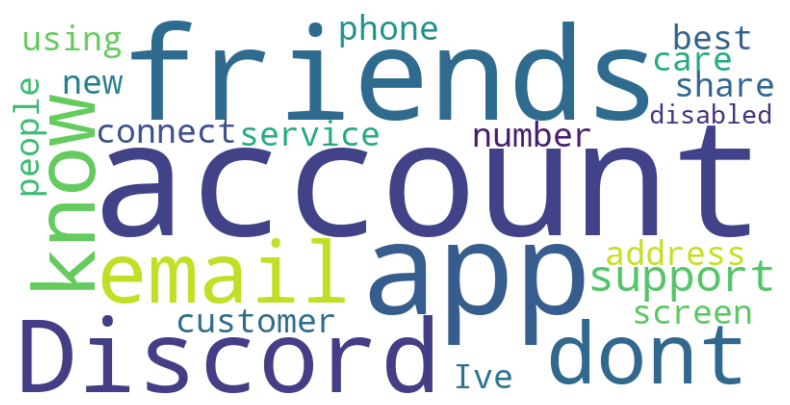

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Function to generate and display word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Function to extract top positive phrases from reviews
def extract_positive_phrases(reviews):
    positive_reviews = reviews[reviews['Sentiment_Score'] > 0.7]  # Adjust threshold as needed
    phrase_counts = Counter()
    for text in positive_reviews['Body']:
        words = text.split()
        for i in range(len(words) - 2):  
            phrase = ' '.join(words[i:i+2])  # Extract 3-word phrases
            phrase_counts[phrase] += 1
    top_phrases = phrase_counts.most_common(50)  # Adjust top_n as needed
    return [phrase for phrase, _ in top_phrases]

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract positive phrases
    positive_phrases_brand = extract_positive_phrases(brand_reviews)
    print("Top Positive Phrases:")
    print(positive_phrases_brand)
    
    # Generate and display word cloud
    print("Word Cloud:")
    generate_wordcloud(' '.join(positive_phrases_brand))


Now, **Do for negative reviews!**

In [139]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to extract top negative phrases from reviews
def extract_negative_phrases(reviews):
    negative_reviews = reviews[reviews['Sentiment_Score'] < 0.3]  # Adjust threshold as needed
    phrase_counts = Counter()
    for text in negative_reviews['Body']:
        words = text.split()
        for i in range(len(words) - 1):
            phrase = ' '.join(words[i:i+3])  # Extract 3-word phrases
            phrase_counts[phrase] += 1
    top_phrases = phrase_counts.most_common(10)  # Adjust top_n as needed
    return [phrase for phrase, _ in top_phrases]

# Function to extract top words from topics
def extract_top_words(lda_model, count_vectorizer, top_n=10):
    topics = lda_model.components_
    top_words_per_topic = []
    for topic in topics:
        top_words_indices = topic.argsort()[-top_n:]
        top_words = [count_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Iterate over each brand
for brand in reviews['brand'].unique():
    brand_reviews = reviews[reviews['brand'] == brand]
    print(f"\nBrand: {brand}")
    
    # Extract negative phrases
    negative_phrases_brand = extract_negative_phrases(brand_reviews)
    print("Top Negative Phrases:")
    print(negative_phrases_brand)
    
    # Initialize CountVectorizer to convert text to a matrix of token counts
    count_vectorizer_brand = CountVectorizer(ngram_range=(2, 2))  # Extract 2-word phrases
    # Fit and transform the text data
    count_matrix_brand = count_vectorizer_brand.fit_transform(brand_reviews['Stemmed_Tokens'].apply(lambda x: ' '.join(x)))
    # Initialize LDA model
    lda_model_brand = LatentDirichletAllocation(n_components=5, random_state=42)
    # Fit LDA model
    lda_model_brand.fit(count_matrix_brand)
    # Extract top words from topics
    top_words_per_topic_brand = extract_top_words(lda_model_brand, count_vectorizer_brand)
    print("Top Topics:")
    for i, top_words in enumerate(top_words_per_topic_brand):
        print(f"Topic {i+1}: {', '.join(top_words)}")



Brand: WhatsApp
Top Negative Phrases:
['this app', 'use this app', 'the same thing', 'the web version', 'and now they', 'with the app', 'worst customer service', 'Terrible customer service', 'messages and photos', 'the WhatsApp Business']
Top Topics:
Topic 1: phone number, absolutely nothing, whatsapp support, every time, great app, easy use, send message, customer service, use whatsapp, do not
Topic 2: support team, customer service, use whatsapp, not understand, phone number, whatsapp business, use app, customer support, can not, do not
Topic 3: good app, use whatsapp, terrible customer, message whatsapp, like whatsapp, delete message, what app, can not, customer service, do not
Topic 4: waste time, bad customer, privacy policy, whatsapp good, family friend, what app, can not, use whatsapp, customer service, do not
Topic 5: phone number, use app, use whatsapp, video call, good app, not want, message photo, customer service, can not, do not

Brand: Signal
Top Negative Phrases:
['the 

**HYPOTHESIS TESTING**

This is part to test the hypothesis

In [140]:
# Scenario 1: ANOVA
# Null hypothesis: The average sentiment score of Discord, Signal, and WhatsApp reviews are equal.
# Alternative hypothesis: At least one of the average sentiment scores is different.

# Hypothesis 1: ANOVA test
anova_result = stats.f_oneway(
    reviews[reviews['brand'] == 'Discord']['Sentiment_Score'],
    reviews[reviews['brand'] == 'Signal']['Sentiment_Score'],
    reviews[reviews['brand'] == 'WhatsApp']['Sentiment_Score']
)

print("Scenario 1 - ANOVA Test:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

Scenario 1 - ANOVA Test:
F-statistic: 31.100045842671815
p-value: 7.252934823280493e-14


In [141]:
# Hypothesis 2: Positive sentiment scores are significantly higher than negative sentiment scores for each brand.
brands = ['Discord', 'Signal', 'WhatsApp']

for brand in brands:
    # Filter positive and negative sentiment scores for each brand
    positive_sentiment = reviews[(reviews['brand'] == brand) & (reviews['Sentiment_Score'] > 0)]['Sentiment_Score']
    negative_sentiment = reviews[(reviews['brand'] == brand) & (reviews['Sentiment_Score'] < 0)]['Sentiment_Score']
    
    # Match lengths of positive and negative sentiment scores
    min_len = min(len(positive_sentiment), len(negative_sentiment))
    positive_sentiment = positive_sentiment.sample(min_len, random_state=42)
    negative_sentiment = negative_sentiment.sample(min_len, random_state=42)

    # Perform paired samples t-test for each brand
    t_test_result = stats.ttest_rel(positive_sentiment, negative_sentiment)

    # Print results
    print(f"{brand} T-test Result:")
    print("t-statistic:", t_test_result.statistic)
    print("p-value:", t_test_result.pvalue)
    print()

Discord T-test Result:
t-statistic: 49.95952065798322
p-value: 8.006550652087763e-129

Signal T-test Result:
t-statistic: 5.646170540343256
p-value: 0.02996556678017504

WhatsApp T-test Result:
t-statistic: 42.10269246268231
p-value: 7.752020144868337e-93



In [142]:
# Scenario 3: Chi-square Test of Independence
# Null hypothesis: There is no association between the sentiment category and the brand.
# Alternative hypothesis: There is an association between the sentiment category and the brand.

# First, convert sentiment scores to sentiment categories (positive, negative, neutral)
reviews['Sentiment Category'] = pd.cut(reviews['Sentiment_Score'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

# Create a contingency table
contingency_table = pd.crosstab(reviews['brand'], reviews['Sentiment Category'])

chi2_result = stats.chi2_contingency(contingency_table)

print("\nScenario 3 - Chi-square Test of Independence:")
print("Chi-square statistic:", chi2_result[0])
print("p-value:", chi2_result[1])
print("Degrees of freedom:", chi2_result[2])


Scenario 3 - Chi-square Test of Independence:
Chi-square statistic: 52.64404795658389
p-value: 1.0115866792561802e-10
Degrees of freedom: 4


In [143]:
contingency_table

Sentiment Category,Negative,Neutral,Positive
brand,,,
Discord,265,226,159
Signal,2,6,9
WhatsApp,94,182,163


/var/folders/h2/ws329tlx2tj_9vdbqdyj50v40000gn/T/ipykernel_32151/3842032247.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="brand", y="Sentiment_Score", data=reviews, ci="sd")


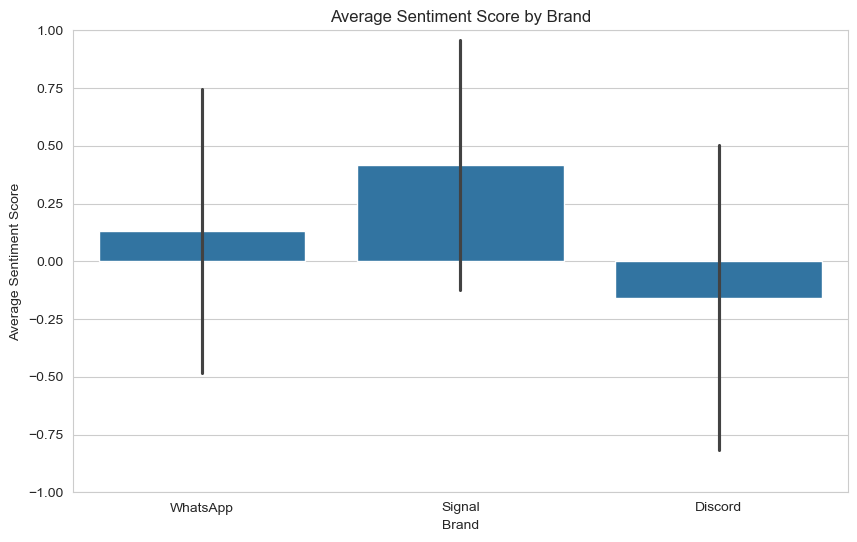

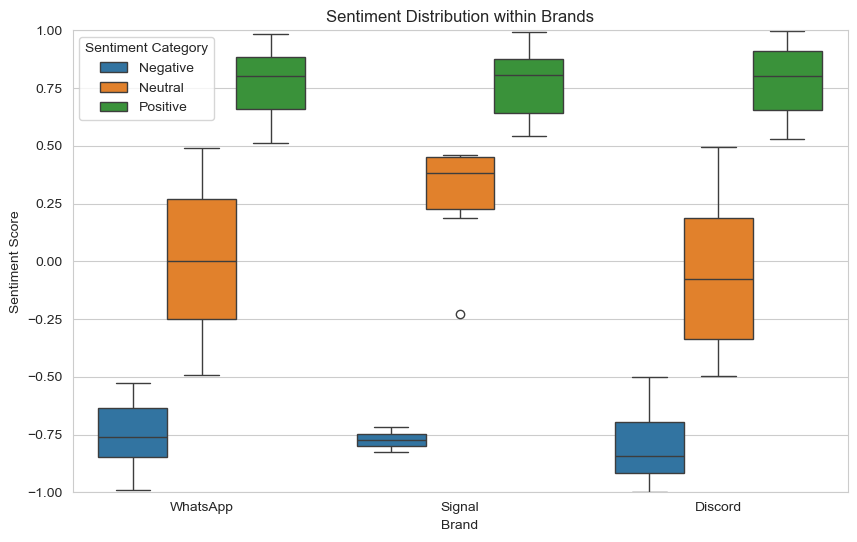

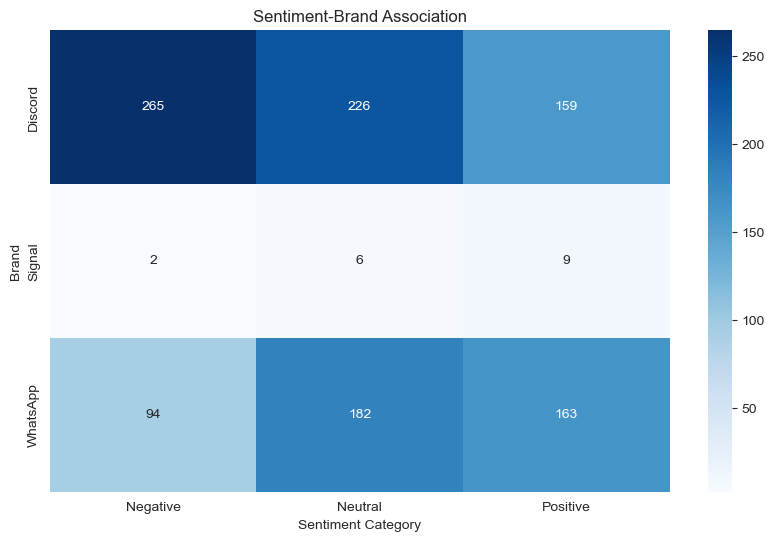

In [144]:
# Set seaborn style
sns.set_style("whitegrid")

# Hypothesis 1: Sentiment Comparison by Brand
plt.figure(figsize=(10, 6))
sns.barplot(x="brand", y="Sentiment_Score", data=reviews, ci="sd")
plt.title("Average Sentiment Score by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.ylim(-1, 1)
plt.show()
#plt.savefig('images/average_sentiment_score_by_brand.png')

# Hypothesis 2: Sentiment Comparison within Brands
plt.figure(figsize=(10, 6))
sns.boxplot(x="brand", y="Sentiment_Score", hue="Sentiment Category", data=reviews)
plt.title("Sentiment Distribution within Brands")
plt.xlabel("Brand")
plt.ylabel("Sentiment Score")
plt.legend(title="Sentiment Category")
plt.ylim(-1, 1)
plt.show()
#plt.savefig('images/sentiment_score_within_brand.png')

# Hypothesis 3: Sentiment-Brand Association
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d")
plt.title("Sentiment-Brand Association")
plt.xlabel("Sentiment Category")
plt.ylabel("Brand")
plt.show()
#plt.savefig('images/sentiment_brand_association.png')